#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Sep  4 10:23:50 2018
Modified Oct 2020, Oct 2021, Oct 2023

@author: Said Ladjal,Isabelle Bloch
"""

In [272]:
#%% SECTION 1 -- inclusion of packages


import numpy as np
import platform
import tempfile
import os
import matplotlib.pyplot as plt
from scipy import ndimage as ndip
from skimage import io as skio
from skimage import measure


import skimage.morphology as morpho 
from skimage.segmentation import watershed 
from skimage.draw import line
import skimage.feature as skf
from scipy import ndimage as ndi

In [219]:
#%% SECTION 2 -- Useful functions

def viewimage(im,normalise=True,MINI=0.0, MAXI=255.0):
    """ Cette fonction fait afficher l'image EN NIVEAUX DE GRIS 
        dans gimp. Si un gimp est deja ouvert il est utilise.
        Par defaut normalise=True. Et dans ce cas l'image est normalisee 
        entre 0 et 255 avant d'être sauvegardee.
        Si normalise=False MINI et MAXI seront mis a 0 et 255 dans l'image resultat

        Questa funzione mostra l'immagine IN SCALA DI GRIGI in GIMP. Se GIMP 
        è già aperto, verrà utilizzato. Per impostazione predefinita, normalize=True.
        In questo caso, l'immagine viene normalizzata tra 0 e 255 prima di essere salvata. Se normalize=False, i valori MIN e MAX saranno impostati su 0 e 255 nell'immagine risultante.
        
    """
    imt=np.float32(im.copy())
    if platform.system()=='Darwin': #on est sous mac
        prephrase='open -a GIMP '
        endphrase=' ' 
    elif platform.system()=='Linux': #SINON ON SUPPOSE LINUX (si vous avez un windows je ne sais comment faire. Si vous savez dites-moi.)
        prephrase='gimp '
        endphrase= ' &'
    elif platform.system()=='Windows':
        prephrase='start /B "D:/GIMP/bin/gimp-2.10.exe" -a '#Remplacer D:/... par le chemin de votre GIMP
        endphrase= ''
    else:
        print('Systeme non pris en charge par l affichage GIMP')
        return 'erreur d afficahge'
    if normalise:
        m=imt.min()
        imt=imt-m
        M=imt.max()
        if M>0:
            imt=imt/M

    else:
        imt=(imt-MINI)/(MAXI-MINI)
        imt[imt<0]=0
        imt[imt>1]=1
    
    nomfichier=tempfile.mktemp('TPIMA.png')
    commande=prephrase +nomfichier+endphrase
    skio.imsave(nomfichier,imt)
    os.system(commande)


def viewimage_color(im,normalise=True,MINI=0.0, MAXI=255.0):
    """ Cette fonction fait afficher l'image EN NIVEAUX DE GRIS 
        dans gimp. Si un gimp est deja ouvert il est utilise.
        Par defaut normalise=True. Et dans ce cas l'image est normalisee 
        entre 0 et 255 avant d'être sauvegardee.
        Si normalise=False MINI(defaut 0) et MAXI (defaut 255) seront mis a 0 et 255 dans l'image resultat
        

        Questa funzione mostra l'immagine IN SCALA DI GRIGI in GIMP. 
        Se GIMP è già aperto, verrà utilizzato. Per impostazione predefinita, 
        normalise=True. In questo caso, l'immagine viene normalizzata tra 0 
        e 255 prima di essere salvata. Se normalise=False, i valori MINI 
        (impostati per default a 0) e MAXI (impostati per default a 255) 
        saranno impostati a 0 e 255 nell'immagine risultante.
    """
    imt=np.float32(im.copy())
    if platform.system()=='Darwin': #on est sous mac
        prephrase='open -a GIMP '
        endphrase=' ' 
    elif platform.system()=='Linux': #SINON ON SUPPOSE LINUX (si vous avez un windows je ne sais comment faire. Si vous savez dites-moi.)
        prephrase='gimp '
        endphrase= ' &'
    elif platform.system()=='Windows':
        prephrase='start /B "D:/GIMP/bin/gimp-2.10.exe" -a '#Remplacer D:/... par le chemin de votre GIMP
        endphrase= ''
    else:
        print('Systeme non pris en charge par l affichage GIMP')
        return 'erreur d afficahge'
    
    if normalise:
        m=imt.min()
        imt=imt-m
        M=imt.max()
        if M>0:
            imt=imt/M
    else:
        imt=(imt-MINI)/(MAXI-MINI)
        imt[imt<0]=0
        imt[imt>1]=1
    
    nomfichier=tempfile.mktemp('TPIMA.pgm')
    commande=prephrase +nomfichier+endphrase
    skio.imsave(nomfichier,imt)
    os.system(commande)


def strel(forme,taille,angle=45):
    """renvoie un element structurant de forme  
     'diamond'  boule de la norme 1 fermee de rayon taille
     'disk'     boule de la norme 2 fermee de rayon taille
     'square'   carre de cote taille (il vaut mieux utiliser taille=impair)
     'line'     segment de langueur taille et d'orientation angle (entre 0 et 180 en degres)
      (Cette fonction n'est pas standard dans python)

      Restituisce un elemento strutturante di forma:

'diamond': una sfera chiusa di norma 1 con un raggio di dimensione
'disk': una sfera chiusa di norma 2 con un raggio di dimensione
'square': un quadrato di lato di dimensione (è meglio usare dimensione dispari)
'line': un segmento di lunghezza dimensione e orientamento angolo 
        (compreso tra 0 e 180 gradi)
    """

    if forme == 'diamond':
        return morpho.diamond(taille)
    if forme == 'disk':
        return morpho.disk(taille)
    if forme == 'square':
        return morpho.square(taille)
    if forme == 'line':
        angle=int(-np.round(angle))
        angle=angle%180
        angle=np.float32(angle)/180.0*np.pi
        x=int(np.round(np.cos(angle)*taille))
        y=int(np.round(np.sin(angle)*taille))
        if x**2+y**2 == 0:
            if abs(np.cos(angle))>abs(np.sin(angle)):
                x=int(np.sign(np.cos(angle)))
                y=0
            else:
                y=int(np.sign(np.sin(angle)))
                x=0
        rr,cc=line(0,0,y,x)
        rr=rr-rr.min()
        cc=cc-cc.min()
        img=np.zeros((rr.max()+1,cc.max()+1) )
        img[rr,cc]=1
        return img
    raise RuntimeError('Erreur dans fonction strel: forme incomprise')

            

def couleurs_alea(im):
    """ 
    Donne des couleurs aleatoires a une image en niveau de gris.
    Cette fonction est utile lorsque le niveua de gris d'interprete comme un numero
      de region. Ou encore pour voir les leger degrades d'une teinte de gris.

    Assegna colori casuali a un'immagine in scala di grigi. Questa funzione 
    è utile quando il livello di grigio è interpretato come un numero di regione 
    o per visualizzare leggeri sfumature di una tonalità di grigio.
      """
    sh=im.shape
    out=np.zeros((sh[0],sh[1],3),dtype=np.uint8)
    nbcoul=np.int32(im.max())
    tabcoul=np.random.randint(0,256,size=(nbcoul+1,3))
    tabcoul[0,:]=0
    for k in range(sh[0]):
        for l in range(sh[1]):
            out[k,l,:]=tabcoul[im[k,l]]
    return out

def gris_depuis_couleur(im):
    """ Transforme une image couleur en image a niveaux de gris"""
    return im[:,:,:3].sum(axis=2)/3

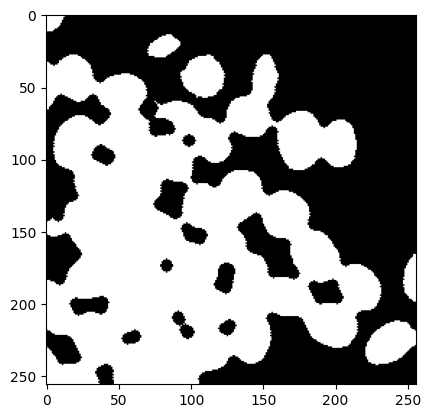

In [220]:
#%% SECTION 3 -- Examples of functions for this work

# Binary images 
#im1=skio.imread('images/cellbin.bmp')
im=skio.imread('images/cafe.bmp')*255


# Gray-scale images
#im=skio.imread('images/retina2.gif')
#im=skio.imread('bat200.bmp')
#im=skio.imread('bulles.bmp')
#im=gris_depuis_couleur (skio.imread('cailloux.png'))
#im=gris_depuis_couleur(skio.imread('cailloux2.png'))
#im=skio.imread('laiton.bmp')
#print(im.max())

plt.imshow(im,cmap="gray",vmin=0, vmax=255)

# viewimage(im) - Utilisable à la place de plt.imshow si Gimp est installé.

se=strel('disk',4)

# dilation
dil=morpho.dilation(im,se)
plt.imshow(dil,cmap="gray",vmin=0, vmax=255)
plt.savefig('grafico.png')#mia aggiunta

# erosion
ero=morpho.erosion(im,se)
plt.imshow(ero,cmap="gray",vmin=0, vmax=255)

#opening
open=morpho.opening(im,se)
plt.imshow(open,cmap="gray",vmin=0, vmax=255)

#closing
close=morpho.closing(im,se)
plt.imshow(close,cmap="gray",vmin=0, vmax=255)

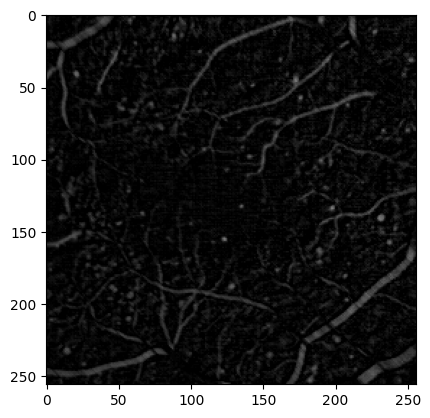

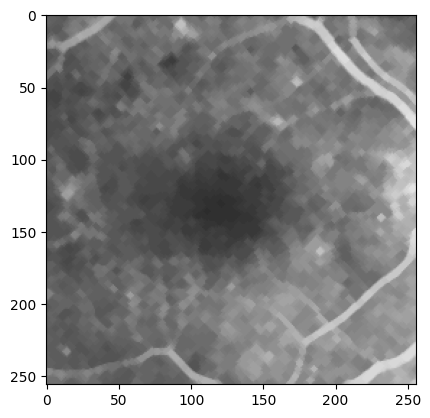

In [221]:
#%% Top-hat transforme
im=skio.imread('images/retina2.gif')
t=10
se=strel('line',t,-45)
ch=im-morpho.opening(im,se)
plt.imshow(ch,cmap="gray",vmin=0, vmax=255)
plt.show()

#%%  Alternate sequential filter
im=skio.imread('images/retina2.gif')
imt=im.copy()
N=3
for k in range(N):
    se=strel('disk',k)
    imt=morpho.closing(morpho.opening(imt,se),se)
plt.imshow(imt,cmap="gray",vmin=0, vmax=255)

TypeError: watershed() got an unexpected keyword argument 'watershed_line'

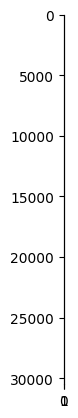

In [365]:
#%% Watersheds
im=skio.imread("images/bat200.bmp")
#added for the images
if len(im.shape)>2 and im.shape[2]==3:
    im=gris_depuis_couleur(im)
se=morpho.disk(1)

grad=morpho.dilation(im,se)-morpho.erosion(im,se)
grad=np.int32(grad>40)*grad
plt.imshow(grad,cmap="gray")

inverted_grad=255-grad
local_mini = skf.peak_local_max(inverted_grad) #il n'y a pas de fonction local_min...
peak_mask=np.zeros_like(inverted_grad, dtype=bool)
peak_mask[tuple(local_mini.T)]=True
markers,_= measure.label(peak_mask, return_num=True)
plt.imshow(local_mini,cmap="gray")

labels = watershed(grad, markers,watershed_line=True)
plt.imshow(couleurs_alea(labels))
# viewimage_color(couleurs_alea(labels)) - Utilisable si gimp est installé

# visualization of the result
segm=labels.copy()
for i in range(segm.shape[0]):
    for j in range(segm.shape[1]):
        if segm[i,j] == 0: 
            segm[i,j]=255
        else:
            segm[i,j]=0
#superimposition of segmentation contours on the original image
contourSup=np.maximum(segm,im)
plt.imshow(contourSup,cmap="gray") 

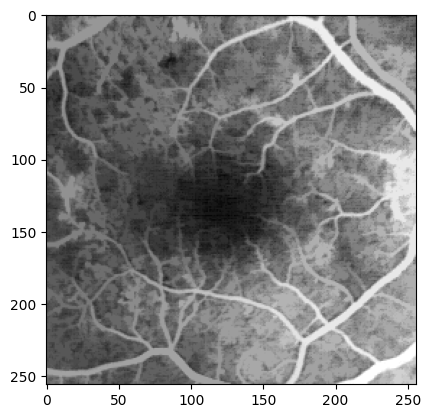

In [312]:
#%% reconstruction

im=skio.imread('images/retina2.gif')
se4=strel('disk',4)
open4=morpho.opening(im,se4)
reco=morpho.reconstruction(open4,im)
plt.imshow(reco,cmap="gray")


TP1 MORPHO

1. Mathematical morfology on gray-scale images

In [337]:
#1.1
#requires to be set only one parameter between the shape and the size of the structuring element
def morphological_op1(op, se_shape, se_size, image):

    if(len(se_shape)>0 and se_size>0):
        print("Not applicable! Requirements not met.\n Set only one parameter between the shape and the size of the structuring element.")
    else:
        im = skio.imread(image)
        #added for the images
        if len(im.shape)>2 and im.shape[2]==3:
            im=gris_depuis_couleur(im)
            
        plt.imshow(im, cmap="gray")
        plt.show()
        
        plot_pos=1
        #different sizes
        if len(se_shape)>0:
            l=[(1,se_shape), (3,se_shape), (7,se_shape), (10,se_shape)]
        #different shapes
        elif (se_size!=-1):
            l=[(se_size,"diamond"), (se_size,"disk"), (se_size,"square"), (se_size,"line")]

        plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)
        for sz, sh in l:
            if(op=="dilation"):
                morpho_op=morpho.dilation(im, strel(sh, sz))
            if(op=="erosion"):
                morpho_op=morpho.erosion(im, strel(sh, sz))
            if(op=="opening"):
                morpho_op=morpho.opening(im, strel(sh, sz))
            if(op=="closing"):
                morpho_op=morpho.closing(im, strel(sh, sz))
            #plt.figure(figsize=(8, 8))
            plt.subplot(2, 2, plot_pos)
            plt.title(f"{op} with {sh} of size {sz}")
            plt.imshow(morpho_op, cmap="gray")
            plot_pos+=1


In [341]:
#prova
image=skio.imread("images/bulles.bmp")

if len(image.shape) == 2:
    print("L'immagine è binaria.")
else:
    print("L'immagine non è binaria.")

L'immagine non è binaria.


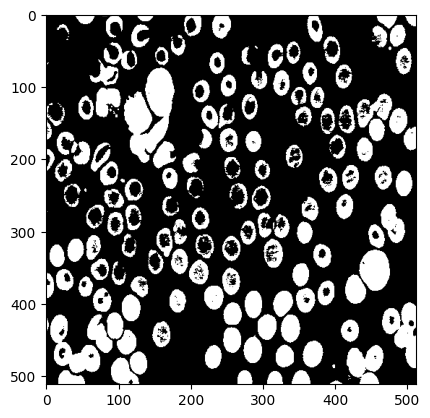

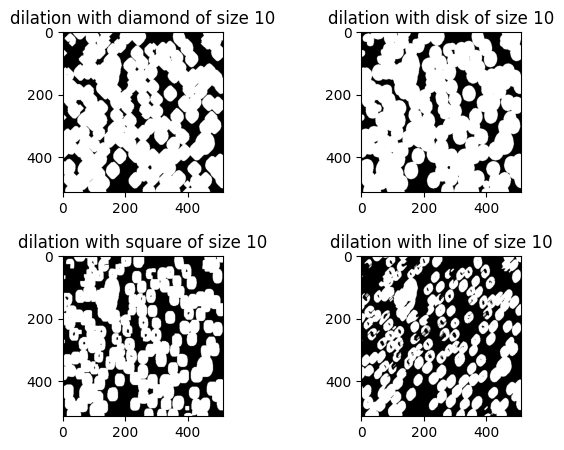

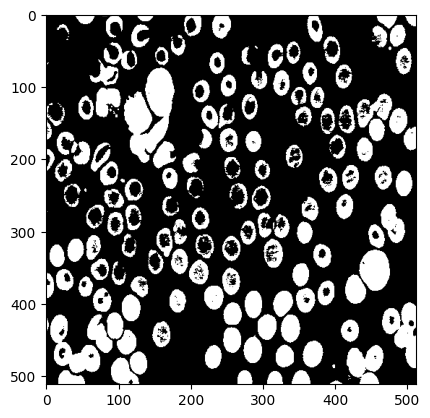

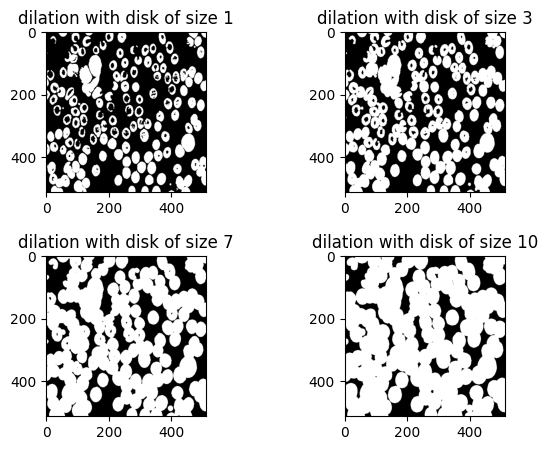

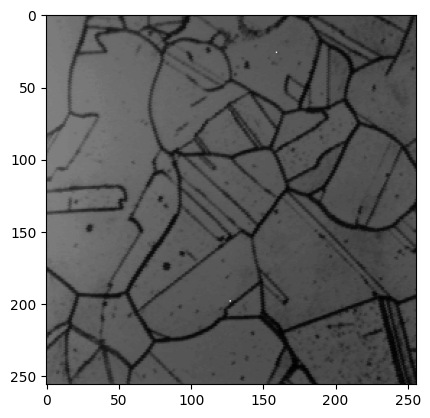

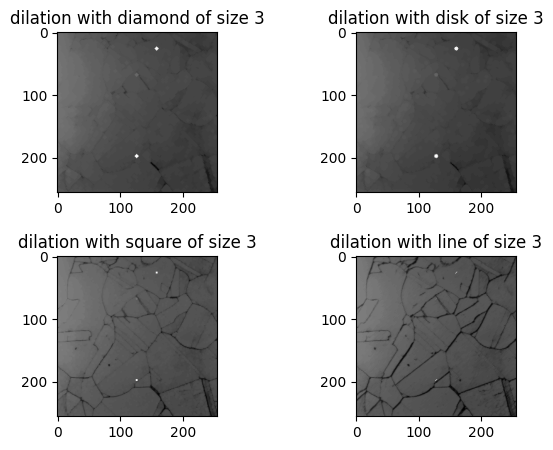

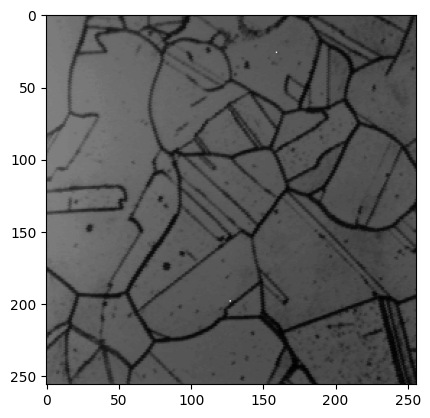

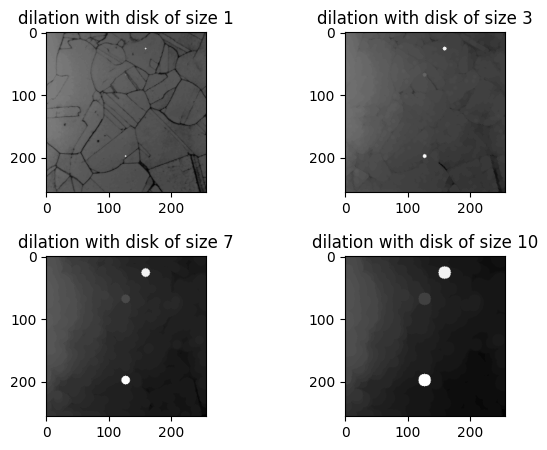

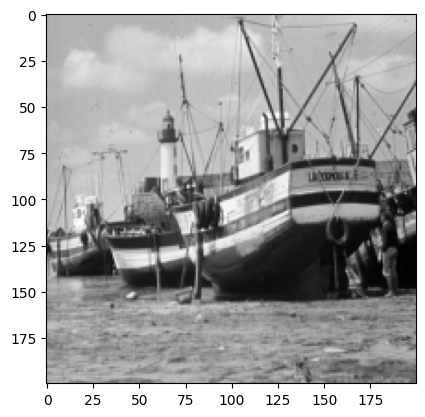

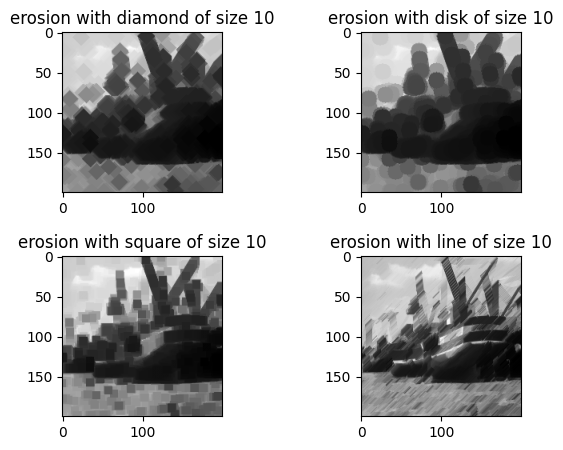

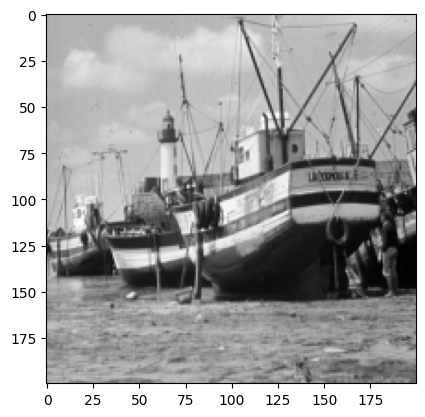

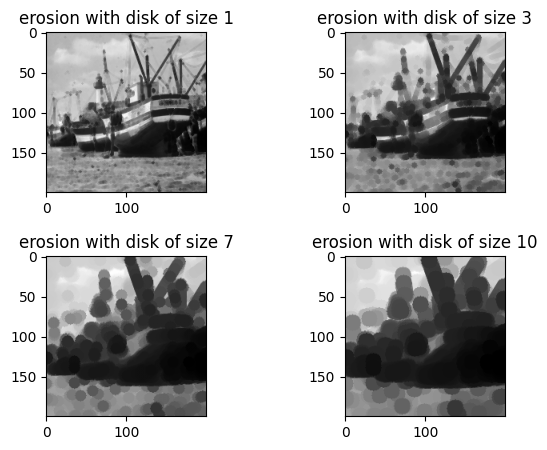

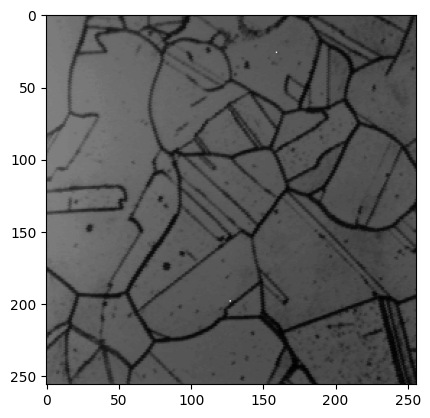

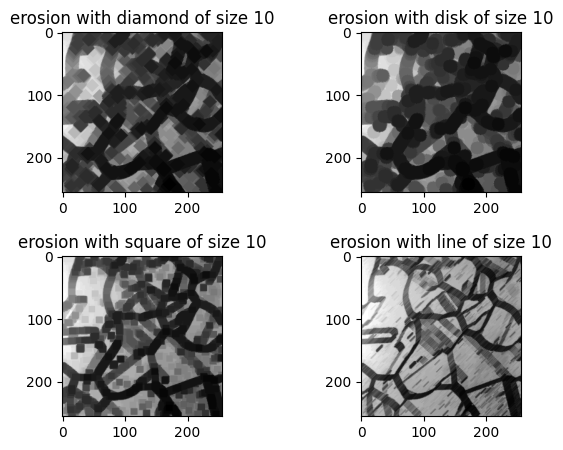

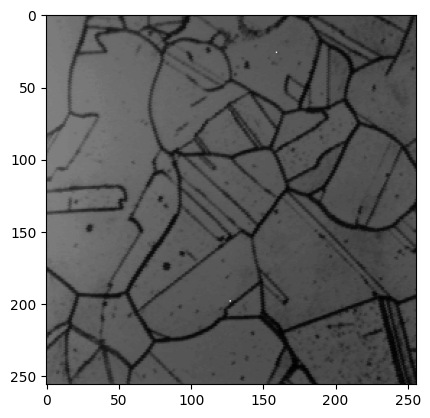

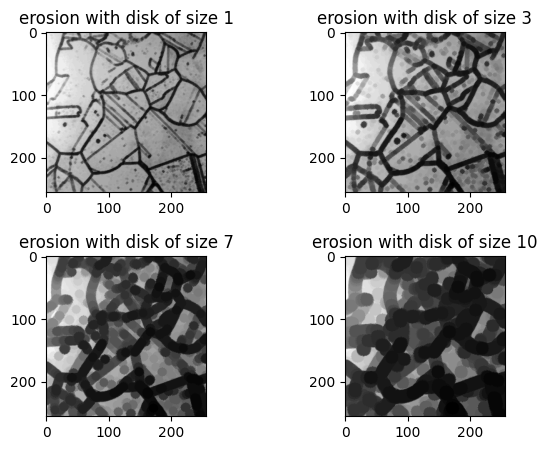

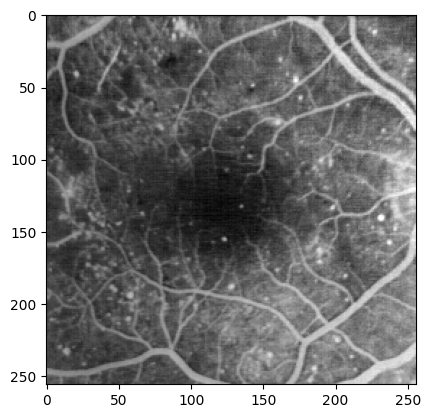

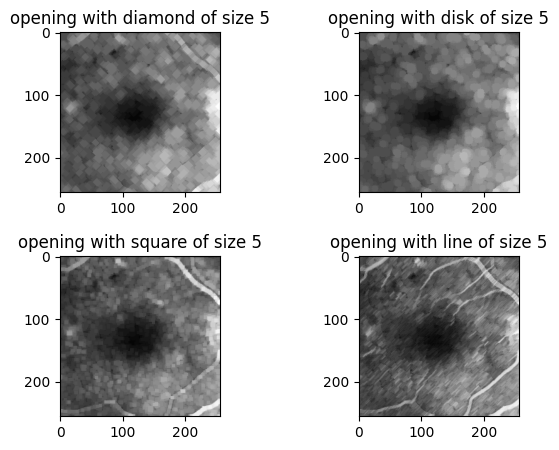

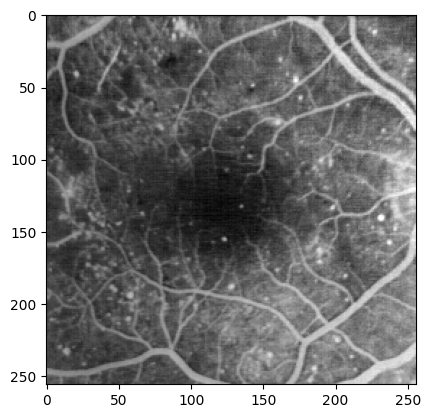

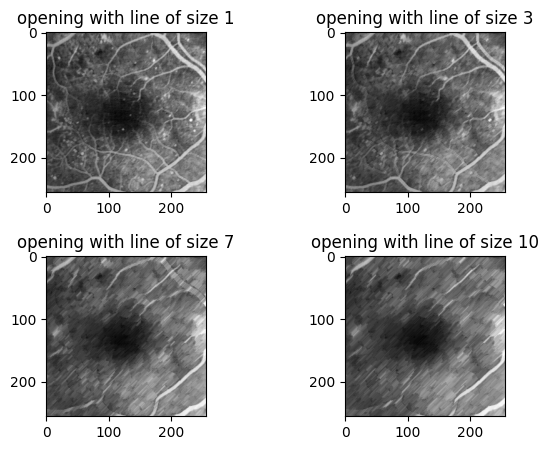

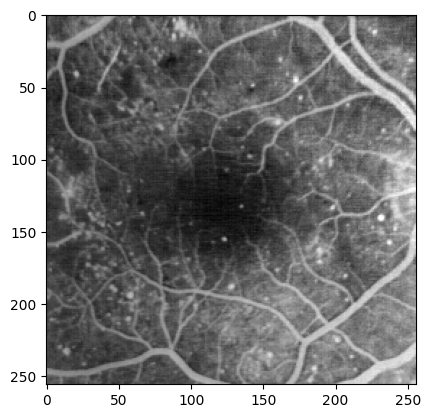

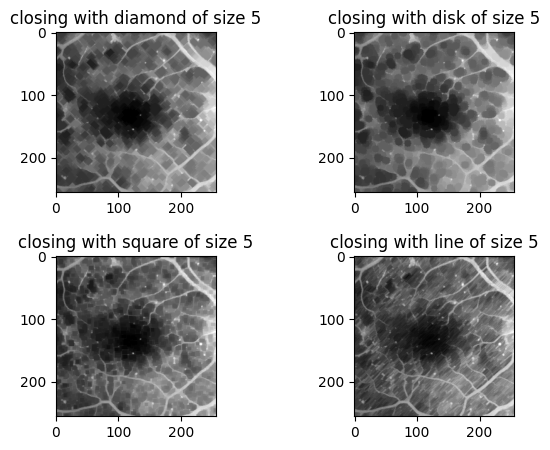

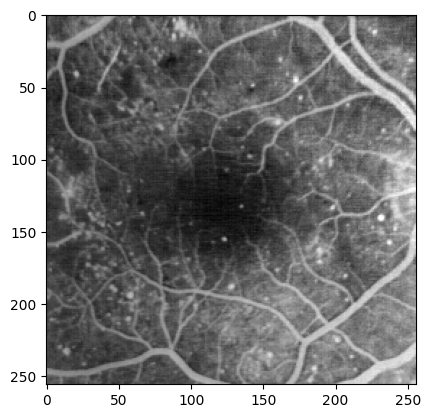

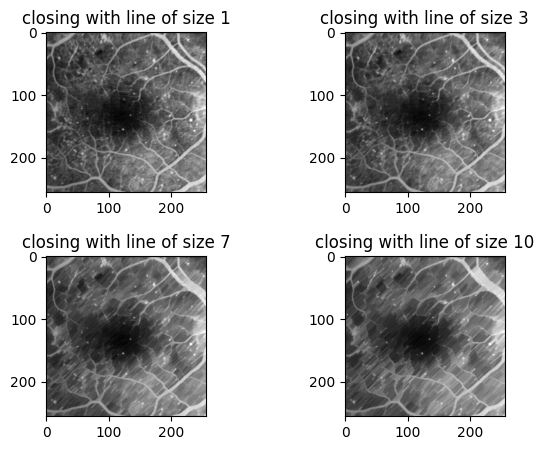

In [351]:
#dilation
morphological_op1("dilation", "", 10, "images/cellbin.bmp")#different shape, same size
plt.show()
morphological_op1("dilation", "disk", -1, "images/cellbin.bmp")#same shape, different size
plt.show()

morphological_op1("dilation", "", 3, "images/laiton.bmp")#different shape, same size
plt.show()
morphological_op1("dilation", "disk", -1, "images/laiton.bmp")#same shape, different size
plt.show()

#erosion
morphological_op1("erosion", "", 10, "images/bat200.bmp")#different shape, same size
plt.show()
morphological_op1("erosion", "disk", -1, "images/bat200.bmp")#same shape, different size
plt.show()

morphological_op1("erosion", "", 10, "images/laiton.bmp")#different shape, same size
plt.show()
morphological_op1("erosion", "disk", -1, "images/laiton.bmp")#same shape, different size
plt.show()

#opening
morphological_op1("opening", "", 5, "images/retina2.gif")#same shape, different size
plt.show()
morphological_op1("opening", "line", -1, "images/retina2.gif")#same shape, different size
plt.show()

morphological_op1("closing", "", 5, "images/retina2.gif")#same shape, different size
plt.show()
morphological_op1("closing", "line", -1, "images/retina2.gif")#same shape, different size
plt.show()


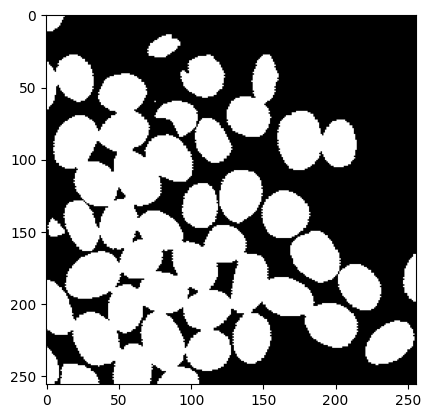

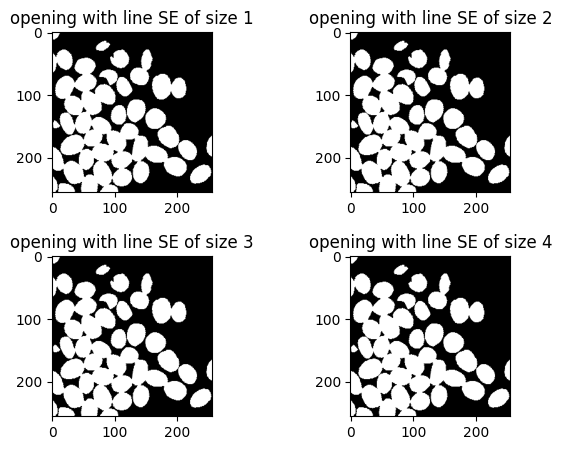

In [278]:
morphological_op1("opening", "line", -1, "images/cafe.bmp")#same shape, different size
plt.show()

In [282]:
#1.3
def test_idempotent_property(image):
    im = skio.imread(image)*255
    if len(im.shape)>2 and im.shape[2]==3:
            im=gris_depuis_couleur(im)

    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)
    #dilation by a square of size 3x3 followed by a dilation by a square of size 5x5
    double_dilation=morpho.dilation(morpho.dilation(im, strel("square", 3)), strel("square", 5))
    plt.subplot(1, 2, 1)
    plt.title("dilation by a square of size 3x3 followed\nby a dilation by a square of size 5x5")
    plt.imshow(double_dilation, cmap="gray")

    #dilation by a square of size 5x5 
    single_dilation=morpho.dilation(im, strel("square", 5))
    plt.subplot(1, 2, 2)
    plt.title("dilation by a square of size 5x5 ")
    plt.imshow(single_dilation, cmap="gray")
    plt.show()

    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)
    #opening by a square of size 3x3 followed by an opening by a square of size 5x5
    double_opening=morpho.opening(morpho.opening(im, strel("square", 3)), strel("square", 5))
    plt.subplot(1, 2, 1)
    plt.title("opening by a square of size 3x3 followed\nby an opening by a square of size 5x5")
    plt.imshow(double_opening, cmap="gray")

    #opening by a square of size 5x5 
    single_opening=morpho.opening(im, strel("square", 5))
    plt.subplot(1, 2, 2)
    plt.title("opening by a square of size 5x5 ")
    plt.imshow(single_opening, cmap="gray")
    plt.show()

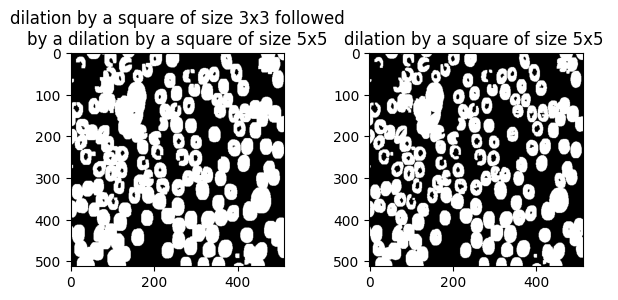

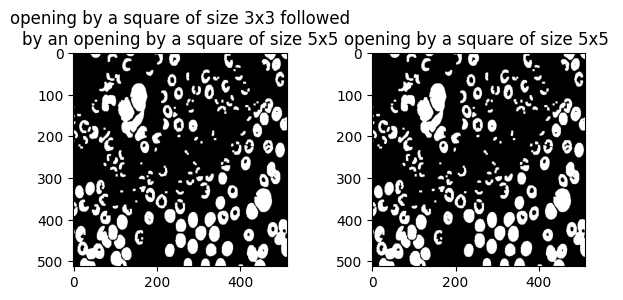

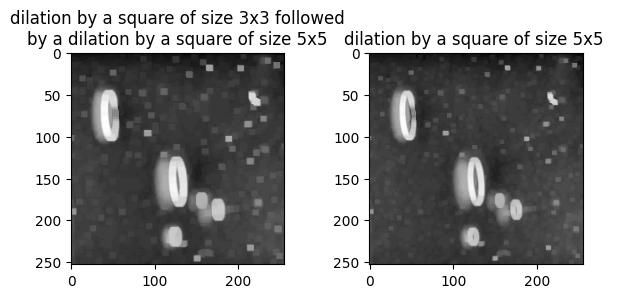

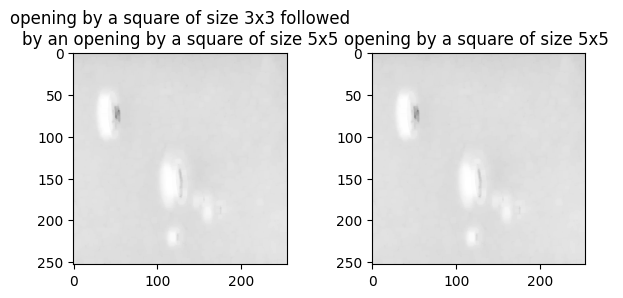

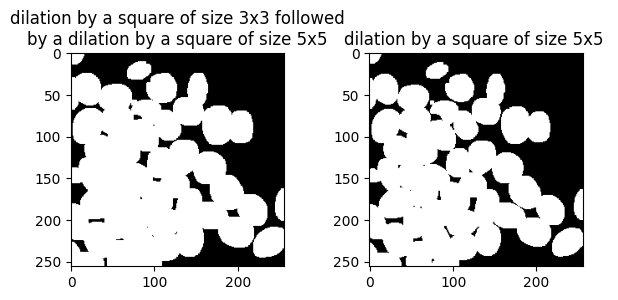

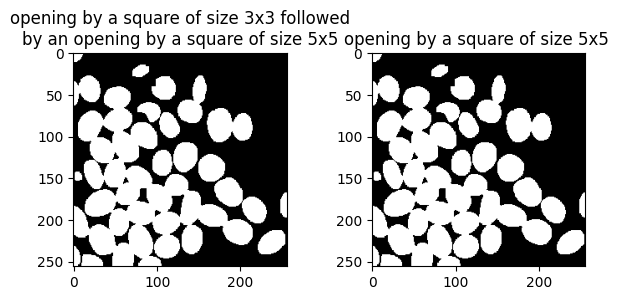

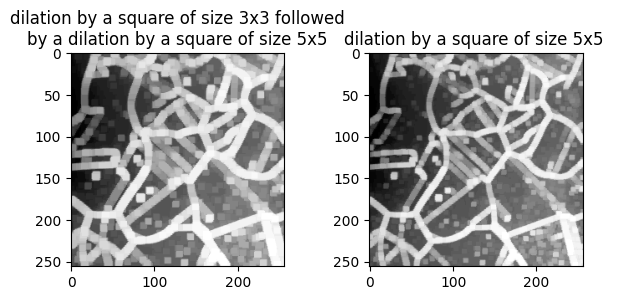

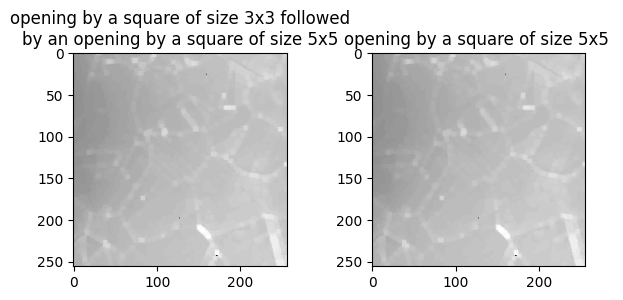

In [281]:
test_idempotent_property('images/cellbin.bmp')
test_idempotent_property('images/bulles.bmp')
test_idempotent_property('images/cafe.bmp')
test_idempotent_property('images/laiton.bmp')

In [360]:
#1.4
def top_hat_examples(image, shape):
    im = skio.imread(image)
    if len(im.shape)>2 and im.shape[2]==3:
            im=gris_depuis_couleur(im)

    structuring_elements = [
        (shape, 3),
        (shape, 5),
        (shape, 7),
    ]

    plt.figure(figsize=(12, 8))
    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)

    # Original image
    plt.subplot(1, len(structuring_elements) + 1, 1)
    plt.title("Original Image")
    plt.imshow(im, cmap="gray")

    # Apply top-hat transform with varying size and shape of the structuring element
    for i, (se_shape, se_size) in enumerate(structuring_elements):
        se = strel(se_shape, se_size)
        opened_image = morpho.opening(im, se)
        top_hat_result = im - opened_image

        plt.subplot(1, len(structuring_elements) + 1, i + 2)
        plt.title(f"Top-Hat with {se_shape} SE of\n size {se_size}")
        plt.imshow(top_hat_result, cmap="gray")

    plt.show()

In [362]:
def bottom_hat_examples(image, shape):
    im = skio.imread(image)
    if len(im.shape)>2 and im.shape[2]==3:
            im=gris_depuis_couleur(im)
    structuring_elements = [
        (shape, 3),
        (shape, 5),
        (shape, 7),
    ]

    plt.figure(figsize=(12, 8))
    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)

    # Original image
    plt.subplot(1, len(structuring_elements) + 1, 1)
    plt.title("Original Image")
    plt.imshow(im, cmap="gray")

    # Apply top-hat transform with varying size and shape of the structuring element
    for i, (se_shape, se_size) in enumerate(structuring_elements):
        se = strel(se_shape, se_size)
        closed_image = morpho.closing(im, se)
        top_hat_result = closed_image-im

        plt.subplot(1, len(structuring_elements) + 1, i + 2)
        plt.title(f"Bottom-Hat with {se_shape} of\n size {se_size}")
        plt.imshow(top_hat_result, cmap="gray")

    plt.show()

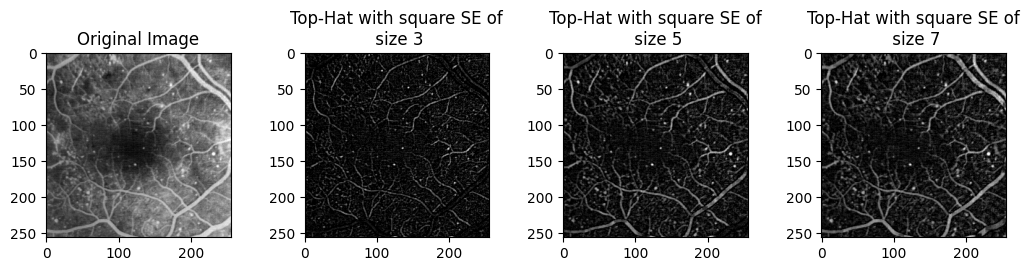

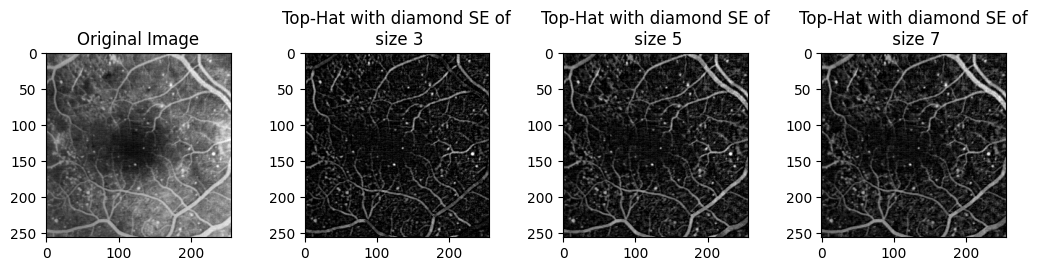

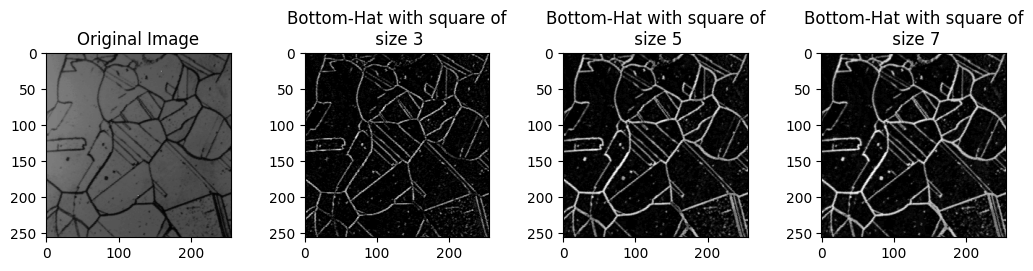

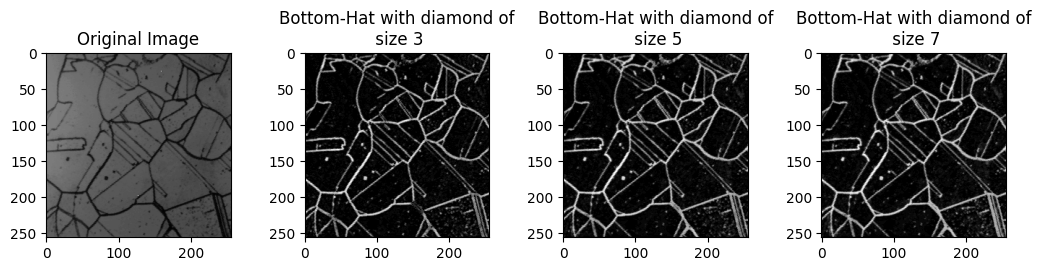

In [364]:
top_hat_examples("images/retina2.gif", "square")
top_hat_examples("images/retina2.gif", "diamond")
bottom_hat_examples("images/laiton.bmp", "square")
bottom_hat_examples("images/laiton.bmp", "diamond")

In [296]:
#1.5
def white_top_hat(image):
    im = skio.imread(image)*255
    if len(im.shape)>2 and im.shape[2]==3:
            im=gris_depuis_couleur(im)
    angles=[0, 45, 90, 135]

    results = []

    for angle in angles:
        se = strel('line', 50, angle)
        opened_image = morpho.opening(im, se)
        results.append(opened_image)
    
    max_result= np.maximum.reduce(results)#CONTROLLA PER IL REDUCE!!!!

    # Plot the original image
    plt.figure(figsize=(10, 5))
    plt.subplot(131)  # Original image
    plt.title("Original Image")
    plt.imshow(im,cmap="gray",vmin=0, vmax=255)

    # Plot the structuring element
    plt.subplot(132)  # Structuring element
    plt.title("Structuring Element")
    plt.imshow(se,cmap="gray")

    # Plot the point-wise maximum result
    plt.subplot(133)  # Point-wise maximum result
    plt.title("Point-wise Maximum Result")
    plt.imshow(max_result,cmap="gray",vmin=0, vmax=255)

    plt.show()


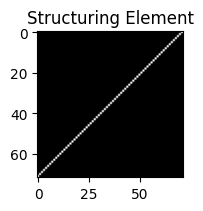

In [294]:
#prova
se=strel("line", 100)
plt.subplot(132)  # Structuring element
plt.title("Structuring Element")
plt.imshow(se,cmap="gray")

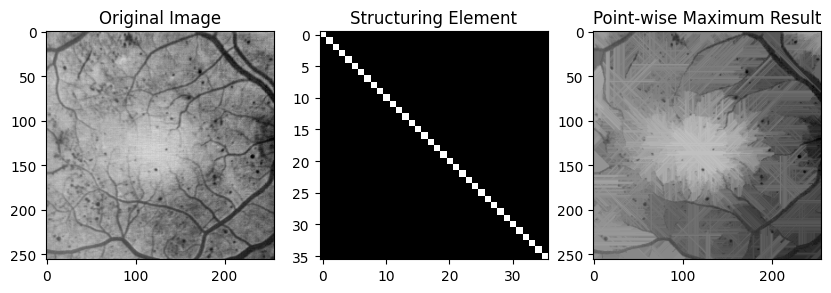

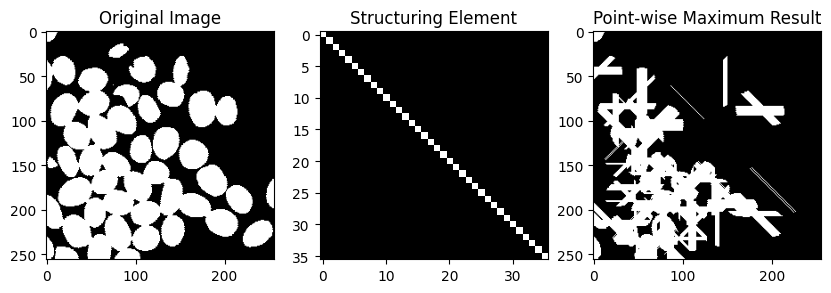

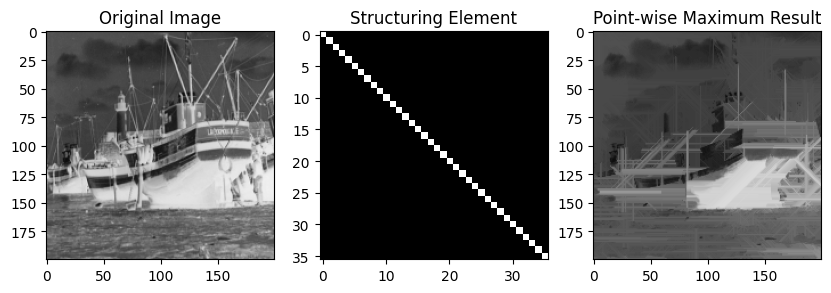

In [297]:
white_top_hat("images/retina2.gif")
white_top_hat("images/cafe.bmp")
white_top_hat("images/bat200.bmp")

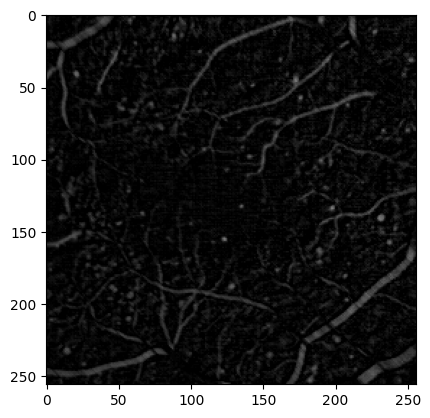

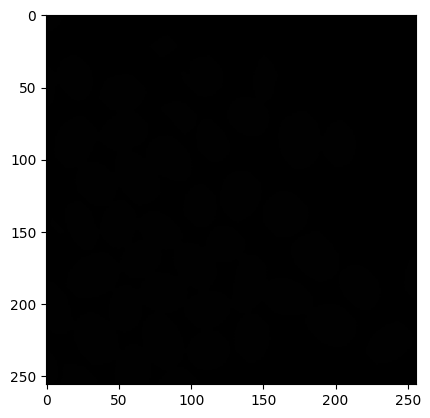

In [238]:
#prova per capire perchè non funziona
im=skio.imread('images/retina2.gif')
t=10
se=strel('line',t,-45)
ch=im-morpho.opening(im,se)
plt.imshow(ch,cmap="gray",vmin=0, vmax=255)
plt.show()

im1 = skio.imread("images/cafe.bmp")
se = strel('line', 10, -45)
opened_image = morpho.opening(im1, se)
plt.imshow(opened_image,cmap="gray",vmin=0, vmax=255)

In [268]:
#2.1
def alternate_sequential_filter(image, max_size):

    # Load an image (you can use your own image)
    im=skio.imread(image)
    if len(im.shape)>2 and im.shape[2]==3:
        im=gris_depuis_couleur(im)

    # List of structuring element shapes and maximum sizes
    se_shapes = ["square", "disk", "diamond"]

    # Initialize an empty list to store the results
    results = [im]

    # Create the sequence with varying structuring elements
    for i in range(0, max_size):
        print(i)
        se_shape = se_shapes[i % len(se_shapes)]
        se=strel(se_shape, i+1)
        result = morpho.closing(morpho.opening(results[-1], se), se)
        results.append(result)

    #plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)
    
    plt.figure(figsize=(15, 5))
    for i, result in enumerate(results):
        plt.subplot(1, len(results), i+1)
        plt.imshow(result, cmap="gray")
        if i==0:
            plt.title("Original\nImage")
        else: 
            plt.title(f'SE: {se_shapes[i % len(se_shapes)]},\n Size: {i}')

    plt.show()


0
1
2
3
4
5
6
7
8
9


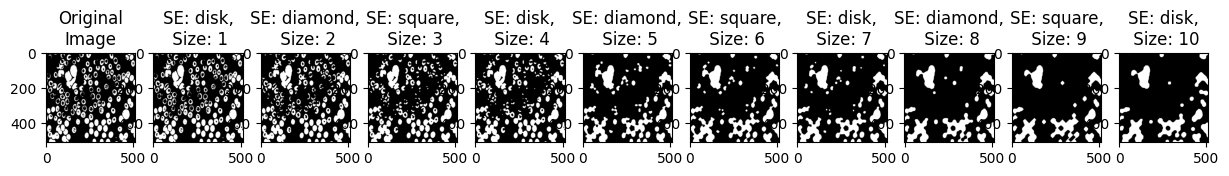

0
1
2
3
4
5
6
7
8
9


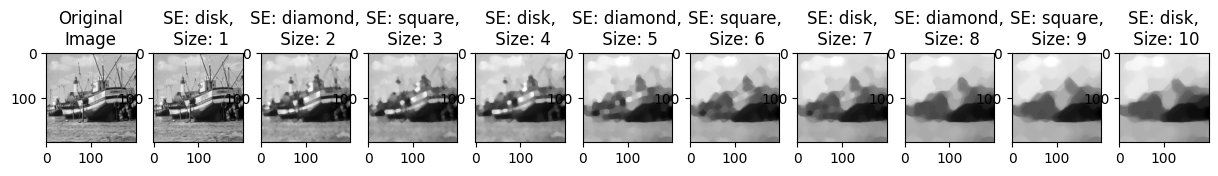

In [269]:
alternate_sequential_filter("images/cellbin.bmp", 10)
alternate_sequential_filter("images/bat200.bmp", 10)

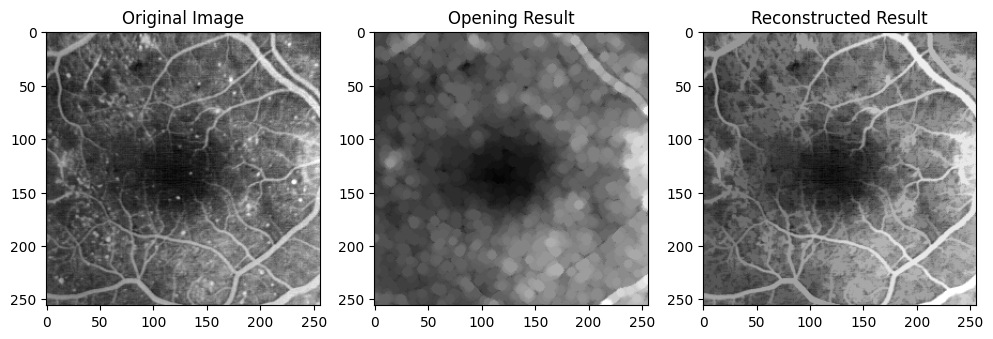

In [298]:
#3.1
im=skio.imread("images/retina2.gif")
if len(im.shape)>2 and im.shape[2]==3:
            im=gris_depuis_couleur(im)
se = strel("disk",4)
open = morpho.opening(im,se)
reco=morpho.reconstruction(open,im)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(im, cmap="gray")

plt.subplot(1, 3, 2)
plt.title("Opening Result")
plt.imshow(open, cmap="gray")

plt.subplot(1, 3, 3)
plt.title("Reconstructed Result")
plt.imshow(reco, cmap="gray")

plt.show()

In [ ]:
#3.2 
#DEVO SCRIVERE CODICE????


In [309]:
#3.3
def alternate_sequential_filter_with_reconstruction(image, max_size):

    # Load an image (you can use your own image)
    im=skio.imread(image)
    if len(im.shape)>2 and im.shape[2]==3:
            im=gris_depuis_couleur(im)
    # List of structuring element shapes and maximum sizes
    se_shapes = ["square", "disk", "diamond"]

    # Initialize an empty list to store the results
    results = [im]

    # Create the sequence with varying structuring elements
    for i in range(0, max_size):
        print(i)
        se_shape = se_shapes[i % len(se_shapes)]
        se=strel(se_shape, i+1)

        res_opened=morpho.opening(results[-1], se)
        results.append(res_opened)
        res_opened_reconst=morpho.reconstruction(res_opened, results[-1])
        results.append(res_opened_reconst)
        res_opened_closed=morpho.closing(res_opened, se)
        results.append(res_opened_closed)
        res_opened_closed_reconst=morpho.reconstruction(res_opened_closed,res_opened, method="erosion" )
        results.append(res_opened_closed_reconst)

    #plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)
    
    plt.figure(figsize=(15, 5))
    for i, result in enumerate(results):
        plt.subplot(1, len(results), i+1)
        plt.imshow(result, cmap="gray")
        if i==0:
            plt.title("Original\nImage")
        else:
            if i%2==0:
                plt.title("reconstructed")
            else:
                plt.title(f'SE: {se_shapes[i % len(se_shapes)]},\n Size: {i}')

    plt.show()

0
1
2
3


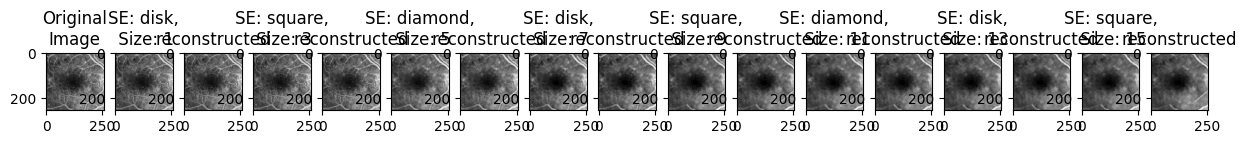

In [310]:
alternate_sequential_filter_with_reconstruction("images/retina2.gif", 4)

In [305]:
#4.1

def morphological_gradient(image):
    # Load the image (you can use your own image)
    im = skio.imread(image)
    if len(im.shape)>2 and im.shape[2]==3:
            im=gris_depuis_couleur(im)
    
    # Define an elementary structuring element of size 1
    se = strel('disk', 1)

    # Compute the dilation and erosion
    dilated = morpho.dilation(im, se)
    eroded = morpho.erosion(im, se)

    # Calculate the morphological gradient as the difference
    gradient = dilated - eroded

    # Plot the original image, dilation, erosion, and the gradient
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 4, 1)
    plt.title("Original Image")
    plt.imshow(im, cmap="gray")

    plt.subplot(1, 4, 2)
    plt.title("Dilated Image")
    plt.imshow(dilated, cmap="gray")

    plt.subplot(1, 4, 3)
    plt.title("Eroded Image")
    plt.imshow(eroded, cmap="gray")

    plt.subplot(1, 4, 4)
    plt.title("Morphological Gradient")
    plt.imshow(gradient, cmap="gray")

    plt.show()
    return gradient


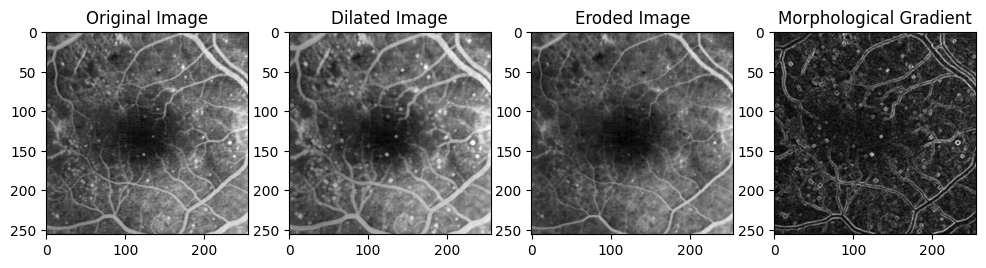

(256, 256)


TypeError: watershed() got an unexpected keyword argument 'watershed_line'

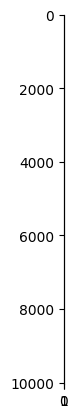

In [326]:
gradient=morphological_gradient("images/retina2.gif")

In [316]:
#4.2

def watershed(grad):
    
    if len(grad.shape)>2 and grad.shape[2]==3:
            grad=gris_depuis_couleur(im)
    se=morpho.disk(1)

    

    inverted_grad=255-grad
    local_mini = skf.peak_local_max(inverted_grad) #il n'y a pas de fonction local_min...
    peak_mask=np.zeros_like(inverted_grad, dtype=bool)
    peak_mask[tuple(local_mini.T)]=True
    markers,_= measure.label(peak_mask, return_num=True)
    plt.imshow(local_mini,cmap="gray")

    labels = watershed(grad, markers,watershed_line=True)
    plt.imshow(couleurs_alea(labels))
    # viewimage_color(couleurs_alea(labels)) - Utilisable si gimp est installé

    # visualization of the result
    segm=labels.copy()
    for i in range(segm.shape[0]):
        for j in range(segm.shape[1]):
            if segm[i,j] == 0: 
                segm[i,j]=255
            else:
                segm[i,j]=0
    #superimposition of segmentation contours on the original image
    contourSup=np.maximum(segm,im)
    plt.imshow(contourSup,cmap="gray") 


TypeError: watershed() got an unexpected keyword argument 'watershed_line'

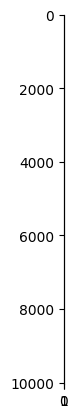

In [318]:
watershed(gradient)

In [259]:
#4.3

def watershed_with_filtering(image):
    im=skio.imread(image)
    if len(im.shape)>2 and im.shape[2]==3:
            im=gris_depuis_couleur(im)
    se=morpho.disk(1)

    closed_im = morpho.closing(im, se)#added filtering of the image

    grad=morpho.dilation(im,se)-morpho.erosion(im,se)

    grad = morpho.closing(grad, se)#added filtering of the gradient

    grad=np.int32(grad>40)*grad
    plt.imshow(grad,cmap="gray")

    inverted_grad=255-grad
    local_mini = skf.peak_local_max(inverted_grad) #il n'y a pas de fonction local_min...
    peak_mask=np.zeros_like(inverted_grad, dtype=bool)
    peak_mask[tuple(local_mini.T)]=True
    markers,_= measure.label(peak_mask, return_num=True)
    plt.imshow(local_mini,cmap="gray")

    labels = watershed(grad, markers,watershed_line=True)
    plt.imshow(couleurs_alea(labels))
    # viewimage_color(couleurs_alea(labels)) - Utilisable si gimp est installé

    # visualization of the result
    plt.figure(figsize=(10, 10))
               
    segm=labels.copy()
    for i in range(segm.shape[0]):
        for j in range(segm.shape[1]):
            if segm[i,j] == 0: 
                segm[i,j]=255
            else:
                segm[i,j]=0
    #superimposition of segmentation contours on the original image
    contourSup=np.maximum(segm,im)
    plt.subplot(221)
    plt.imshow(im, cmap="gray")
    plt.title("Original Image")
    
    plt.subplot(222)
    plt.imshow(closed_im, cmap="gray")
    plt.title("Closed Image")
    
    plt.subplot(223)
    plt.imshow(grad, cmap="gray")
    plt.title("Filtered Gradient Image")
    
    plt.subplot(224)
    plt.imshow(contour_sup, cmap="gray")
    plt.title("Segmentation Result with Contours")
    
    plt.show()


In [260]:
watershed_with_filtering("images/bat200.bmp")

IndexError: tuple index out of range

In [ ]:
#4.4

def watershed_with_dynamic_minima(image, dynamic_threshold):
    # Load the image
    im = skio.imread(image)
    
    # Create a disk-shaped structuring element
    se = morpho.disk(1)
    
    # Apply morphological closing to the original image to enhance features
    closed_im = morpho.closing(im, se)
    
    # Calculate the gradient of the closed image
    grad = morpho.dilation(closed_im, se) - morpho.erosion(closed_im, se)
    
    # Filter the gradient image with closing to merge closely connected regions
    grad = morpho.closing(grad, se)
    
    # Threshold the gradient image
    grad = np.int32(grad > 40) * grad
    
    # Find local minima in the inverted gradient image
    local_minima = skf.peak_local_max(255 - grad, indices=False)
    
    # Eliminate regional minima with a dynamic threshold
    regional_minima = ndi.label(local_minima)[0]
    dynamic_minima = regional_minima >= dynamic_threshold
    markers = ndi.label(dynamic_minima)[0]
    
    # Perform watershed segmentation
    labels = watershed(grad, markers, watershed_line=True)
    
    # Visualize the segmentation result
    plt.figure(figsize=(10, 10))
    
    # Overlay segmentation contours on the original image
    segm = labels.copy()
    for i in range(segm.shape[0]):
        for j in range(segm.shape[1]):
            if segm[i, j] == 0:
                segm[i, j] = 255
            else:
                segm[i, j] = 0
    
    contour_sup = np.maximum(segm, im)
    
    plt.subplot(221)
    plt.imshow(im, cmap="gray")
    plt.title("Original Image")
    
    plt.subplot(222)
    plt.imshow(closed_im, cmap="gray")
    plt.title("Closed Image")
    
    plt.subplot(223)
    plt.imshow(grad, cmap="gray")
    plt.title("Filtered Gradient Image")
    
    plt.subplot(224)
    plt.imshow(contour_sup, cmap="gray")
    plt.title("Segmentation Result with Contours")
    
    plt.show()


In [ ]:
# Example usage with a dynamic threshold value
dynamic_threshold = 3  # You can adjust this threshold value as needed
watershed_with_dynamic_minima('images/bat200.bmp', dynamic_threshold)

In [ ]:
#4.5
#I started from the previous code for watershed with filtering, giusto??
#TO BE CHECKED#4.5
#I started from the previous code for watershed with filtering, giusto??
#TO BE CHECKED

def watershed_with_markers(image, inside_markers, outside_markers):
    # Load the image
    im = skio.imread(image)
    
    # Create a disk-shaped structuring element
    se = morpho.disk(1)
    
    # Apply morphological closing to the original image to enhance features
    closed_im = morpho.closing(im, se)
    
    # Calculate the gradient of the closed image
    grad = morpho.dilation(closed_im, se) - morpho.erosion(closed_im, se)
    
    # Threshold the gradient image
    grad = np.int32(grad > 40) * grad
    
    # Define the marker image 'm' based on inside and outside markers
    m = np.zeros_like(grad)
    
    # Set values in inside markers to 0 and values in outside markers to 255
    m[inside_markers] = 0
    m[outside_markers] = 255
    
    # Compute I' = I AND m
    i_prime = grad & m
    
    # Reconstruct I' by erosion from m
    reconstructed_i = morpho.reconstruction(i_prime, m)
    
    # Compute the watersheds of the reconstructed image
    labels = watershed(reconstructed_i, markers=ndi.label(m)[0], watershed_line=True)
    
    # Visualize the segmentation result
    plt.figure(figsize=(10, 10))
    
    # Overlay segmentation contours on the original image
    segm = labels.copy()
    for i in range(segm.shape[0]):
        for j in range(segm.shape[1]):
            if segm[i, j] == 0:
                segm[i, j] = 255
            else:
                segm[i, j] = 0
    
    contour_sup = np.maximum(segm, im)
    
    plt.subplot(221)
    plt.imshow(im, cmap="gray")
    plt.title("Original Image")
    
    plt.subplot(222)
    plt.imshow(closed_im, cmap="gray")
    plt.title("Closed Image")
    
    plt.subplot(223)
    plt.imshow(reconstructed_i, cmap="gray")
    plt.title("Reconstructed Image")
    
    plt.subplot(224)
    plt.imshow(contour_sup, cmap="gray")
    plt.title("Segmentation Result with Contours")
    
    plt.show()


In [ ]:
# Example usage with manually defined markers (inside and outside)
inside_markers = np.array([[100, 100], [150, 150], [200, 200]])
outside_markers = np.array([[0, 0], [0, 299], [299, 0], [299, 299]])

watershed_with_markers('images/bat200.bmp', inside_markers, outside_markers)

In [ ]:
#4.6
#DEVO SCRIVERE CODICE???


In [ ]:
#finisco codice(chiedo a chatgpt come modificare un codice dandogli quello che ho)
#cerco ifnso come sono registrare immagini tipi colori e vedo le funzioni sopra se posso utilizzarle e cosa risolvono
#do il codice e il rispettivo errore per capire come fare
#controllo il codice e vedo anche se devo aggiungere copy 
#inizio a scrivere report con spiegazioni